# Test TF MNIST Model via Ambassador


Python Dependencies

 * Requests
 * Numpy
 * Matplotlib
 * Tensorflow

## Set up REST and gRPC methods

Install gRPC modules for the prediction protos.

In [5]:
import requests
from requests.auth import HTTPBasicAuth
from random import randint,random
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
from matplotlib import pyplot as plt
import json

OAUTH_API="localhost:8003"

def rest_request(deploymentName,request):
    response = requests.post(
                "http://"+OAUTH_API+"/seldon/"+deploymentName+"/api/v0.1/predictions",
                json=request)
    return response.json() 

def get_token():
    payload = {'grant_type': 'client_credentials'}
    response = requests.post(
                "http://"+OAUTH_API+"/oauth/token",
                auth=HTTPBasicAuth('oauth-key', 'oauth-secret'),
                data=payload)
    token =  response.json()["access_token"]
    return token

def rest_request(request,token):
    headers = {'Authorization': 'Bearer '+token}
    response = requests.post(
                "http://"+OAUTH_API+"/api/v0.1/predictions",
                headers=headers,
                json=request)
    return response.json()
    
def gen_image(arr):
    two_d = (np.reshape(arr, (28, 28)) * 255).astype(np.uint8)
    plt.imshow(two_d,cmap=plt.cm.gray_r, interpolation='nearest')
    return plt

def download_mnist():
    return input_data.read_data_sets("MNIST_data/", one_hot = True)

def predict_rest_mnist(mnist):
    token = get_token()
    batch_xs, batch_ys = mnist.train.next_batch(1)
    chosen=0
    gen_image(batch_xs[chosen]).show()
    data = batch_xs[chosen].reshape((1,784))
    features = ["X"+str(i+1) for i in range (0,784)]
    request = {"data":{"names":features,"ndarray":data.tolist()}}
    predictions = rest_request(request,token)
    print("Route:"+json.dumps(predictions["meta"]["routing"],indent=2))
    fpreds = [ '%.2f' % elem for elem in predictions["data"]["ndarray"][0] ]
    m = dict(zip(predictions["data"]["names"],fpreds))
    print(json.dumps(m,indent=2))


**Ensure you have port forwarded to the Seldon API OAUTH Gateway pod:**

```
kubectl port-forward $(kubectl get pods -n default -l app=seldon-apiserver-container-app -o jsonpath='{.items[0].metadata.name}') -n default 8003:8080
```

In [3]:
mnist = download_mnist()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


{"access_token":"936236d2-8f53-4a21-9d10-45861f39a167","token_type":"bearer","expires_in":43199,"scope":"read write"}


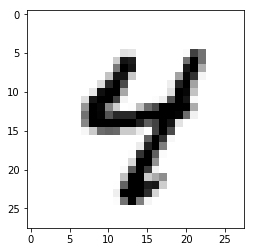

Route:{}
{
  "class:0": "0.00",
  "class:1": "0.00",
  "class:2": "1.00",
  "class:3": "0.00",
  "class:4": "0.00",
  "class:5": "0.00",
  "class:6": "0.00",
  "class:7": "0.00",
  "class:8": "0.00",
  "class:9": "0.00"
}


In [4]:
predict_rest_mnist(mnist)